In [4]:
"""
    Make a fits image cube using real COSMOS galaxies from a catalog describing the training
    sample.

      - The number of images in the cube matches the number of rows in the catalog.
      - Each image size is computed automatically by GalSim based on the Nyquist size.
      - Both galaxies and stars.
      - PSF is a double Gaussian, the same for each galaxy.
      - Galaxies are randomly rotated to remove the imprint of any lensing shears in the COSMOS
        data.
      - The same shear is applied to each galaxy.
      - Noise is Poisson using a nominal sky value of 1.e6 ADU/arcsec^2,
        the noise in the original COSMOS data.
"""
# Copyright (c) 2012-2021 by the GalSim developers team on GitHub
# https://github.com/GalSim-developers
#
# This file is part of GalSim: The modular galaxy image simulation toolkit.
# https://github.com/GalSim-developers/GalSim
#
# GalSim is free software: redistribution and use in source and binary forms,
# with or without modification, are permitted provided that the following
# conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions, and the disclaimer given in the accompanying LICENSE
#    file.
# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions, and the disclaimer given in the documentation
#    and/or other materials provided with the distribution.
#
"""
Demo #6

The sixth script in our tutorial about using GalSim in python scripts: examples/demo*.py.
(This file is designed to be viewed in a window 100 characters wide.)

This script uses real galaxy images from COSMOS observations.  The catalog of real galaxy
images distributed with GalSim only includes 100 galaxies, but you can download a much
larger set of images.  See https://github.com/GalSim-developers/GalSim/wiki for a link
to the download page.

The galaxy images are already convolved with the effective PSF for the original observations,
so GalSim considers the galaxy profile to be the observed image deconvolved by that PSF
(also distributed with the galaxy data).  In this case, we then randomly rotate the galaxies,
apply a given gravitational shear as well as gravitational magnification, and then finally
convolve by a double Gaussian PSF.  The final image can of course have any pixel scale, not
just that of the original images.  The output for this script is to a FITS "data cube".
With DS9, this can be viewed with a slider to quickly move through the different images.


New features introduced in this demo:

- real_cat = galsim.RealGalaxyCatalog(file_name, dir)
- obj = galsim.Gaussian(fwhm, flux)
- obj = galsim.RealGalaxy(real_cat, index, flux)
- obj = obj.rotate(theta)
- obj = obj.magnify(mu)
- image += background
- noise = galsim.PoissonNoise()  # with no sky_level given
- obj.drawImage(..., offset)
- galsim.fits.writeCube([list of images], file_name)
"""

import sys
import os
import math
import logging
import time
import galsim

def main(argv):
    
    logging.basicConfig(format="%(message)s", level=logging.INFO, stream=sys.stdout)
    logger = logging.getLogger("demo6")

    # Define some parameters we'll use below.

    cat_file_name = 'real_galaxy_catalog_23.5_example.fits'
    dir = 'data'
    # Make output directory if not already present.
    if not os.path.isdir('output'):
        os.mkdir('output')
    cube_file_name = os.path.join('output','cube_real.fits')
    psf_file_name = os.path.join('output','psf_real.fits')

    random_seed = 1512413
    sky_level = 1.e6        # ADU / arcsec^2
    pixel_scale = 0.16      # arcsec
    gal_flux = 1.e5         # arbitrary choice, makes nice (not too) noisy images
    gal_g1 = -0.027         #
    gal_g2 = 0.031          #
    gal_mu = 1.082          # mu = ( (1-kappa)^2 - g1^2 - g2^2 )^-1
    psf_inner_fwhm = 0.6    # arcsec
    psf_outer_fwhm = 2.3    # arcsec
    psf_inner_fraction = 0.8  # fraction of total PSF flux in the inner Gaussian
    psf_outer_fraction = 0.2  # fraction of total PSF flux in the inner Gaussian
    ngal = 100

    logger.info('Starting demo script 6 using:')
    logger.info('    - real galaxies from catalog %r',cat_file_name)
    logger.info('    - double Gaussian PSF')
    logger.info('    - pixel scale = %.2f',pixel_scale)
    logger.info('    - Applied gravitational shear = (%.3f,%.3f)',gal_g1,gal_g2)
    logger.info('    - Poisson noise (sky level = %.1e).', sky_level)

    # Read in galaxy catalog
    # Note: dir is the directory both for the catalog itself and also the directory prefix
    # for the image files listed in the catalog.
    # If the images are in a different directory, you may also specify image_dir, which gives
    # the relative path from dir to wherever the images are located.
    real_galaxy_catalog = galsim.RealGalaxyCatalog(cat_file_name, dir=dir)
    logger.info('Read in %d real galaxies from catalog', real_galaxy_catalog.nobjects)

    # Make the double Gaussian PSF
    psf1 = galsim.Gaussian(fwhm = psf_inner_fwhm, flux = psf_inner_fraction)
    psf2 = galsim.Gaussian(fwhm = psf_outer_fwhm, flux = psf_outer_fraction)
    psf = psf1+psf2
    # Draw the PSF with no noise.
    psf_image = psf.drawImage(scale = pixel_scale)
    # write to file
    psf_image.write(psf_file_name)
    logger.info('Created PSF and wrote to file %r',psf_file_name)

    # Build the images
    all_images = []
    for k in range(ngal):
        logger.debug('Start work on image %d',k)
        t1 = time.time()

        # Initialize the random number generator we will be using.
        rng = galsim.UniformDeviate(random_seed+k+1)

        gal = galsim.RealGalaxy(real_galaxy_catalog, index = k, flux=gal_flux)
        logger.debug('   Read in training sample galaxy and PSF from file')
        t2 = time.time()

        # Rotate by a random angle
        theta = 2.*math.pi * rng() * galsim.radians
        gal = gal.rotate(theta)

        # Apply the desired shear
        gal = gal.shear(g1=gal_g1, g2=gal_g2)

        # Also apply a magnification mu = ( (1-kappa)^2 - |gamma|^2 )^-1
        # This conserves surface brightness, so it scales both the area and flux.
        gal = gal.magnify(gal_mu)

        # Make the combined profile
        final = galsim.Convolve([psf, gal])

        # Offset by up to 1/2 pixel in each direction
        # We had previously (in demo4 and demo5) used shift(dx,dy) as a way to shift the center of
        # the image.  Since that is applied to the galaxy, the units are arcsec (since the galaxy
        # profile itself doesn't know about the pixel scale).  Here, the offset applies to the
        # drawn image, which does know about the pixel scale, so the units of offset are pixels,
        # not arcsec.  Here, we apply an offset of up to half a pixel in each direction.
        dx = rng() - 0.5
        dy = rng() - 0.5

        # Draw the profile
        if k == 0:
            # Note that the offset argument may be a galsim.PositionD object or a tuple (dx,dy).
            im = final.drawImage(scale=pixel_scale, offset=(dx,dy))
            xsize, ysize = im.array.shape
        else:
            im = galsim.ImageF(xsize,ysize)
            final.drawImage(im, scale=pixel_scale, offset=(dx,dy))

        logger.debug('   Drew image')
        t3 = time.time()

        # Add a constant background level
        background = sky_level * pixel_scale**2
        im += background

        # Add Poisson noise.  This time, we don't give a sky_level, since we have already
        # added it to the image, so we don't want any more added.  The sky_level parameter
        # really defines how much _extra_ sky should be added above what is already in the image.
        im.addNoise(galsim.PoissonNoise(rng))

        logger.debug('   Added Poisson noise')
        t4 = time.time()

        # Store that into the list of all images
        all_images += [im]
        t5 = time.time()

        logger.debug('   Times: %f, %f, %f, %f',t2-t1, t3-t2, t4-t3, t5-t4)
        logger.info('Image %d: size = %d x %d, total time = %f sec', k, xsize, ysize, t5-t1)

    logger.info('Done making images of galaxies')

    # Now write the image to disk.
    # We write the images to a fits data cube.
    galsim.fits.writeCube(all_images, cube_file_name)
    logger.info('Wrote image to fits data cube %r',cube_file_name)


if __name__ == "__main__":
    main(sys.argv)

Starting demo script 6 using:
    - real galaxies from catalog 'real_galaxy_catalog_23.5_example.fits'
    - double Gaussian PSF
    - pixel scale = 0.16
    - Applied gravitational shear = (-0.027,0.031)
    - Poisson noise (sky level = 1.0e+06).
Read in 100 real galaxies from catalog
Created PSF and wrote to file 'output/psf_real.fits'


OSError: No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True

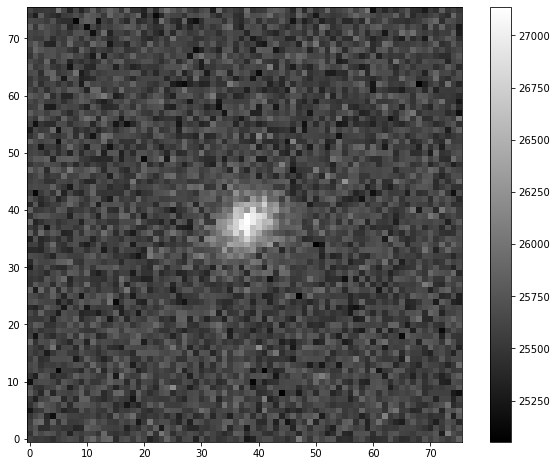

In [8]:
from astropy.utils.data import download_file
from astropy.io import fits
image_file = "GalSim//examples//output//cube_real.fits"
import matplotlib.pyplot as plt
#get data quickly
image_data = fits.getdata(image_file)
#numpy swap rows and cols

plt.figure(figsize=(10,8))
plt.imshow(image_data[99].T,cmap = "gray", origin='lower')
plt.colorbar();

